In [1]:
import os
import json
from datasets import load_dataset
import numpy as np
from pathlib import Path
import pandas as pd

In [2]:
# Load the hallusion dataset
hallusion_dataset = load_dataset("lmms-lab/HallusionBench", "default")
hallusion_dataset = hallusion_dataset['image']

print( len( hallusion_dataset ) )
hallusion_dataset

951


Dataset({
    features: ['category', 'subcategory', 'visual_input', 'set_id', 'figure_id', 'sample_note', 'question_id', 'question', 'gt_answer_details', 'gt_answer', 'filename', 'image'],
    num_rows: 951
})

In [3]:
# Load the pope dataset
pope_dataset = load_dataset("lmms-lab/POPE", "default")
pope_dataset = pope_dataset['test'].filter(lambda x: x['category'] == 'adversarial')

pope_dataset

Filter:   0%|          | 0/9000 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'question_id', 'question', 'answer', 'image_source', 'image', 'category'],
    num_rows: 3000
})

In [4]:
# Get the answers from POPE and HallusionBench
pope_answers = np.array( pope_dataset["answer"] )
hallusion_answers = np.array( hallusion_dataset["gt_answer"] )

In [7]:
# Get the accuracy of each test
results = []
for results_file in Path("../results/responses").glob("*.json"):

    # Read in each file
    fileName = str( results_file )
    with open(results_file, "r") as f:
        json_obj = json.load(f)
    testCase = fileName[9:-15]

    # Get the model answers and the ground truths
    if( "pope" in str( results_file ) ):
        model_answers = np.array( ["yes" if "yes" in line["answer"].lower() else "no" for line in json_obj] )
        ground_truths = pope_answers
    else:
        model_answers = np.array( ["1" if "yes" in line["model_prediction"].lower() else "0" for line in json_obj] )
        ground_truths = hallusion_answers

    # Get the counts
    TP, TN, FP, FN = 0, 0, 0, 0
    N = len( model_answers )
    positives = ["yes", "1"]
    for i in range( len( model_answers ) ):
        model_ans = model_answers[i]
        ground_truth = ground_truths[i]
        if( model_ans == ground_truth and model_ans in ["yes", "1"] ):
            TP += 1
        elif( model_ans == ground_truth and model_ans not in ["yes", "1"] ):
            TN += 1
        elif( model_ans != ground_truth and model_ans in ["yes", "1"] ):
            FP += 1
        else:
            FN += 1

    # Calculate the Metrics
    accuracy = ( TP + TN ) / N
    precision = TP / ( TP + FP )
    recall = TP / ( TP + FN )
    F1 = 2 * precision * recall / ( precision + recall )

    # Save the results
    results.append( [testCase, accuracy, precision, recall, F1, [[TP,FP],[FN,TN]]] )

    # Print out the metrics
    print( testCase )
    print( f"Accuracy : {accuracy}" )
    print( f"Precision: {precision}" )
    print( f"Recall   : {recall}" )
    print( f"F1       : {F1}" )
    print( "-------------------------------------------------------" )

s\responses\internvl_2xPrompting_RAM_hallusion
Accuracy : 0.5310199789695058
Precision: 0.391304347826087
Recall   : 0.20199501246882792
F1       : 0.2664473684210526
-------------------------------------------------------
s\responses\internvl_2xPrompting_RAM_pope
Accuracy : 0.7266666666666667
Precision: 0.8935185185185185
Recall   : 0.5146666666666667
F1       : 0.6531302876480541
-------------------------------------------------------
s\responses\internvl_base_hallusion
Accuracy : 0.526813880126183
Precision: 0.40892193308550184
Recall   : 0.2743142144638404
F1       : 0.3283582089552239
-------------------------------------------------------
s\responses\internvl_base_pope
Accuracy : 0.493
Precision: 0.49222797927461137
Recall   : 0.44333333333333336
F1       : 0.46650298141003155
-------------------------------------------------------
s\responses\internvl_RAM_hallusion
Accuracy : 0.5383806519453207
Precision: 0.4214876033057851
Recall   : 0.2543640897755611
F1       : 0.317262830482

In [8]:
results_df = pd.DataFrame( results, columns = ["Test Case", "Accuracy", "Precision", "Recall", "F1", "Values"] )
results_df.set_index( "Test Case", inplace = True )
results_df

,Accuracy,Precision,Recall,F1,Values
Test Case,,,,,
s\responses\internvl_2xPrompting_RAM_hallusion,0.531020,0.391304,0.201995,0.266447,"[[81, 126], [320, 424]]"
s\responses\internvl_2xPrompting_RAM_pope,0.726667,0.893519,0.514667,0.653130,"[[772, 92], [728, 1408]]"
s\responses\internvl_base_hallusion,0.526814,0.408922,0.274314,0.328358,"[[110, 159], [291, 391]]"
s\responses\internvl_base_pope,0.493000,0.492228,0.443333,0.466503,"[[665, 686], [835, 814]]"
s\responses\internvl_RAM_hallusion,0.538381,0.421488,0.254364,0.317263,"[[102, 140], [299, 410]]"
s\responses\internvl_RAM_pope,0.750667,0.922472,0.547333,0.687029,"[[821, 69], [679, 1431]]"


In [9]:
# Only show pope results
results_df.drop( "Values", axis = 1 ).round(5).iloc[[1,2,4],:].sort_values( "Accuracy", ascending = False )

,Accuracy,Precision,Recall,F1
Test Case,,,,
s\responses\internvl_2xPrompting_RAM_pope,0.72667,0.89352,0.51467,0.65313
s\responses\internvl_RAM_hallusion,0.53838,0.42149,0.25436,0.31726
s\responses\internvl_base_hallusion,0.52681,0.40892,0.27431,0.32836


In [10]:
# Only show HallusionBench Results
results_df.drop( "Values", axis = 1 ).round(5).iloc[[0,3,5],:].sort_values( "Accuracy", ascending = False )

,Accuracy,Precision,Recall,F1
Test Case,,,,
s\responses\internvl_RAM_pope,0.75067,0.92247,0.54733,0.68703
s\responses\internvl_2xPrompting_RAM_hallusion,0.53102,0.39130,0.20200,0.26645
s\responses\internvl_base_pope,0.49300,0.49223,0.44333,0.46650


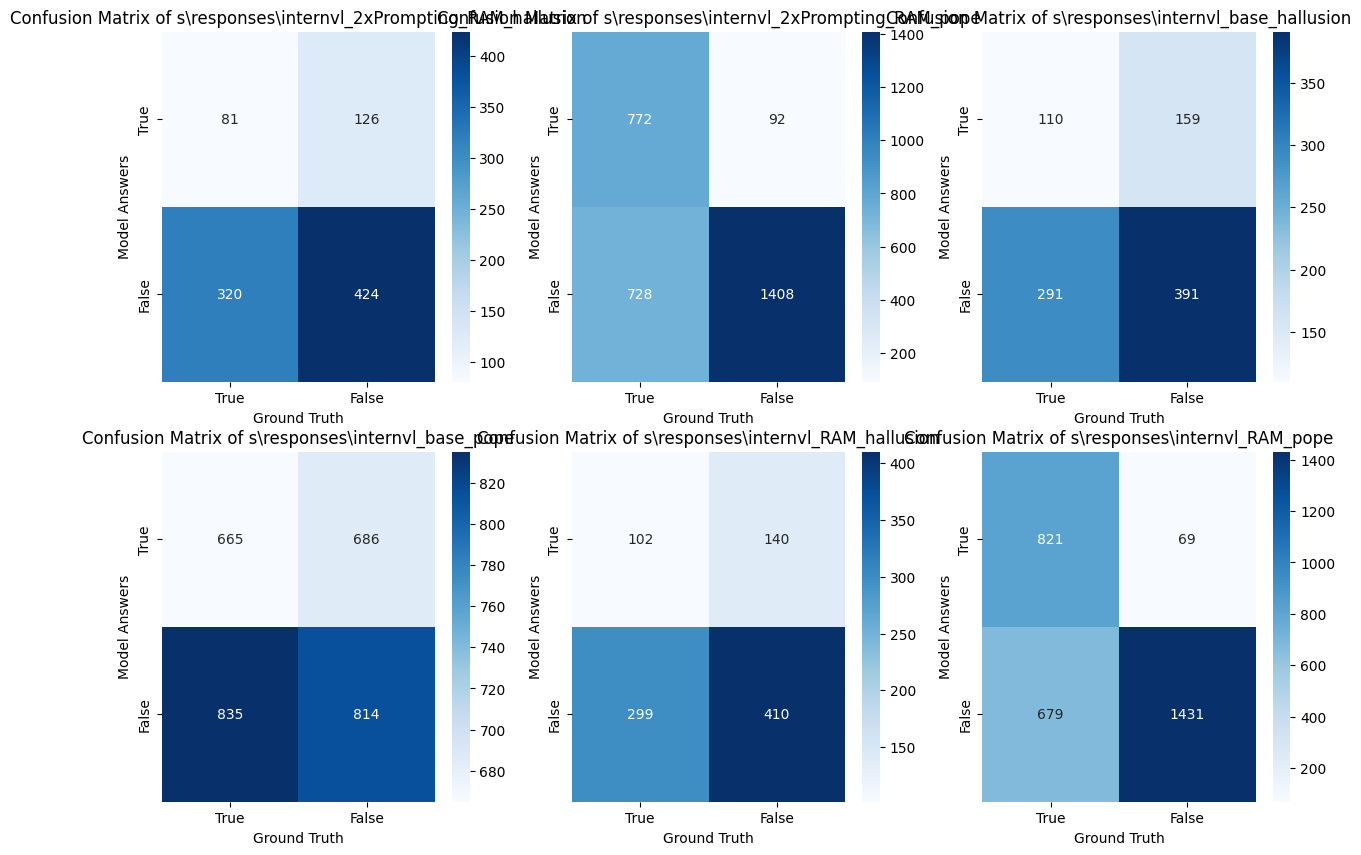

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig, axs = plt.subplots(2, 3, figsize = (15, 10), dpi=100 )
for r in range( len( results_df ) ):
    labels = np.asarray(["True Positive", "False Positive", "False Negative", "True Negative"]).reshape(2,2)
    sns.heatmap( results_df.iloc[r,:]["Values"], annot = True, fmt="1", cmap='Blues', xticklabels = ["True", "False"], yticklabels = ["True", "False"], ax = axs[r // 3,r % 3] )
    axs[r // 3,r % 3].set_xlabel( "Ground Truth" )
    axs[r // 3,r % 3].set_ylabel( "Model Answers" )
    axs[r // 3,r % 3].set_title( "Confusion Matrix of " + results_df.index[r] )

plt.show()

In [12]:
hallusion_categories = np.array( hallusion_dataset["subcategory"] )

In [13]:
# Do a deeper dive into HallusionBench
# Get the accuracy of each test
from collections import defaultdict

hallusion_results = {}
ground_truths = hallusion_answers
for results_file in Path("../results/responses").glob("*hallusion*.json"):

    # Read in each file
    fileName = str( results_file )
    with open(results_file, "r") as f:
        json_obj = json.load( f )
    testCase = fileName[9:-15]

    # Get the model answers and the ground truths
    model_answers = np.array( ["1" if "yes" in line["model_prediction"].lower() else "0" for line in json_obj] )

    categoryResults = defaultdict( lambda : [0,0] )
    for i in range( len( model_answers ) ):
        category = hallusion_categories[i]
        if( model_answers[i] == ground_truths[i] ):
            categoryResults[category][0] += 1
        categoryResults[category][1] += 1
    hallusion_results[testCase] = categoryResults
print( hallusion_results )

{'s\\responses\\internvl_2xPrompting_RAM_hallusion': defaultdict(<function <lambda> at 0x0000024FD5FED580>, {'chart': [84, 130], 'table': [58, 112], 'map': [32, 64], 'ocr': [76, 143], 'illusion': [79, 144], 'math': [56, 108], 'figure': [38, 80], 'video': [82, 170]}), 's\\responses\\internvl_base_hallusion': defaultdict(<function <lambda> at 0x0000024FD5D7DD00>, {'chart': [77, 130], 'table': [53, 112], 'map': [34, 64], 'ocr': [81, 143], 'illusion': [75, 144], 'math': [49, 108], 'figure': [38, 80], 'video': [94, 170]}), 's\\responses\\internvl_RAM_hallusion': defaultdict(<function <lambda> at 0x0000024FD9716B60>, {'chart': [82, 130], 'table': [53, 112], 'map': [29, 64], 'ocr': [75, 143], 'illusion': [75, 144], 'math': [63, 108], 'figure': [44, 80], 'video': [91, 170]})}


In [14]:
hallusion_categories = []
for testCase in hallusion_results:
    
    data = hallusion_results[testCase]
    for category in data:
        hallusion_categories.append( [data[category][0] / data[category][1], category, testCase] )
        
cat_df = pd.DataFrame( hallusion_categories, columns = ["Accuracy", "Category", "TestCase"] )
print( cat_df )

    Accuracy  Category                                        TestCase
0   0.646154     chart  s\responses\internvl_2xPrompting_RAM_hallusion
1   0.517857     table  s\responses\internvl_2xPrompting_RAM_hallusion
2   0.500000       map  s\responses\internvl_2xPrompting_RAM_hallusion
3   0.531469       ocr  s\responses\internvl_2xPrompting_RAM_hallusion
4   0.548611  illusion  s\responses\internvl_2xPrompting_RAM_hallusion
5   0.518519      math  s\responses\internvl_2xPrompting_RAM_hallusion
6   0.475000    figure  s\responses\internvl_2xPrompting_RAM_hallusion
7   0.482353     video  s\responses\internvl_2xPrompting_RAM_hallusion
8   0.592308     chart             s\responses\internvl_base_hallusion
9   0.473214     table             s\responses\internvl_base_hallusion
10  0.531250       map             s\responses\internvl_base_hallusion
11  0.566434       ocr             s\responses\internvl_base_hallusion
12  0.520833  illusion             s\responses\internvl_base_hallusion
13  0.

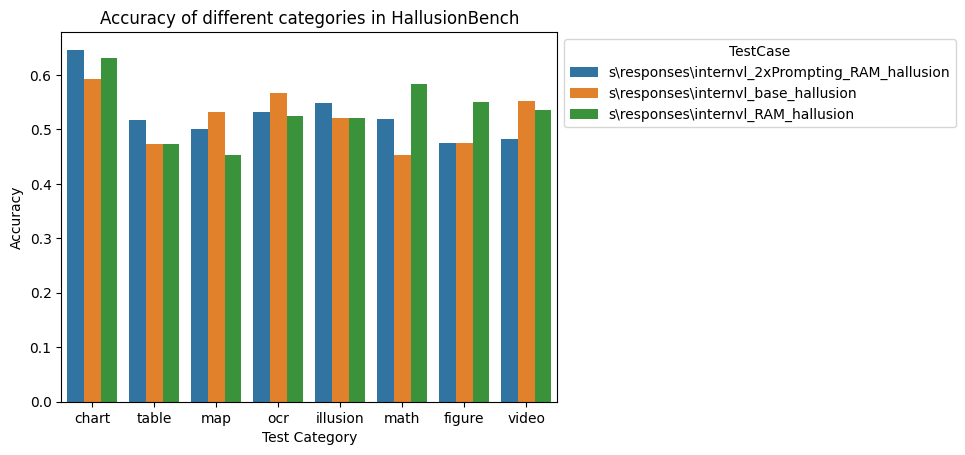

In [15]:
ax = sns.barplot( cat_df, x = "Category", y = "Accuracy", hue = "TestCase" )
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title( "Accuracy of different categories in HallusionBench" )
plt.xlabel( "Test Category" )
plt.show()